<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-2-Kaggle-Challenge/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [x] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# I enjoyed this visualization and want practice using it
fig = plt.figure(figsize=(10,30))
fig = px.scatter_mapbox(data_frame=train, lat='latitude',lon='longitude',color='status_group',opacity=.1)
fig.update_layout(mapbox_style='open-street-map')

<Figure size 720x2160 with 0 Axes>

## cleaning/wrangling

### examine value counts to find which have 0's

In [0]:
cols = train.columns.to_list()
for col in cols:
  print(col,train[col].value_counts(),'\n')

id 2047     1
72310    1
49805    1
51852    1
62091    1
64138    1
57993    1
60040    1
33413    1
35460    1
45699    1
41601    1
43648    1
70263    1
68212    1
20442    1
23134    1
19036    1
29275    1
25177    1
27224    1
4695     1
6742     1
597      1
2644     1
10832    1
53839    1
55886    1
55950    1
53903    1
        ..
52531    1
64821    1
62836    1
58678    1
52595    1
50546    1
56689    1
54640    1
9582     1
15725    1
13676    1
3435     1
28007    1
25958    1
32101    1
30052    1
19811    1
23905    1
21856    1
68939    1
66890    1
73033    1
70984    1
42302    1
48445    1
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64 

amount_tsh 0.00         41639
500.00        3102
50.00         2472
1000.00       1488
20.00         1463
200.00        1220
100.00         816
10.00          806
30.00          743
2000.00        704
250.00         569
300.00         557
5000.00        450
5.00           376
25.00    

In [0]:
# Supporting definitions for Wrangle
def installer_boolean(installer):
  if installer == 'DWE':
    return 1
  else:
    return 0



# assemble list of top funders
funder_top = train.funder.value_counts().index[0:7].to_list()
def funders(funder):
  if funder in funder_top:
    return funder
  else:
    return 'other'

  
  
  
def wrangle(df):
  
  
  # Imputer maintains True False, instead of 1,0. I prefer 1 column instead of 4
  bool_cols = ['public_meeting','permit']
  for col in bool_cols:
    df[col] = df[col].fillna(df[col].value_counts().index[0]).astype(int)
                 
  # convert some values to booleans, fill in missing values, replace suspicious values with nans
  df.installer = df.installer.apply(installer_boolean)
  df.rename(columns = {'installer':'installer_is_DWE'})
  df.funder = df.funder.apply(funders)
  df.scheme_management.fillna('None') # a 'None' category exists, so might as well change nan to None
  
   # change this large count of near-zero outliers to 0, then convert to nan
  df.latitude = df.latitude.replace(-2e-8,0).value_counts()
  
  cols_with_0 = ['latitude','longitude', 'population','construction_year'] # population 1 also exists
  for col in cols_with_0:
    df[col] = df[col].replace(0,np.nan)
    
  df.population = df.population.replace(1,np.nan)

                 
  # remove columns that are "obviously" irrelevant, have too many categorical features, or are redundant
  drop = ['id','date_recorded','num_private','recorded_by','extraction_type',
          'extraction_type_group','water_quality','quantity','source','source_type',
          'waterpoint_type','scheme_name','wpt_name','subvillage','ward',
          'payment','management','lga']

  df = df.drop(columns = drop)
  
  return df
  

## - separate features from labels
## - apply cleaning 
(defined above)

In [0]:
# separate out id columns
train_id = train.id # I don't think this is necessary, but I'm keeping train id
test_id = test.id

# Separate features and labels
train_features = train.drop(columns=['status_group'])
train_labels = train.status_group
test_features = test.copy() # renaming to keep consistancy in variable names

train_features_clean = wrangle(train_features)
test_features_clean = wrangle(test_features)

### - split into train/test data
### - apply pipeline model

In [0]:
X_train,X_val,y_train,y_val = train_test_split(train_features_clean,train_labels)

In [0]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # experimental, fills in nan's by looking at other features for similar data
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [0]:
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                        SimpleImputer(),
                        RandomForestClassifier(n_estimators =100,max_depth=23))

In [0]:
print(X_train.shape,test_features_clean.shape)

(44550, 22) (14358, 22)


In [0]:
pipeline.fit(X_train,y_train)

In [0]:
pipeline.score(X_val,y_val)

0.8035016835016835

### Look at feature importance

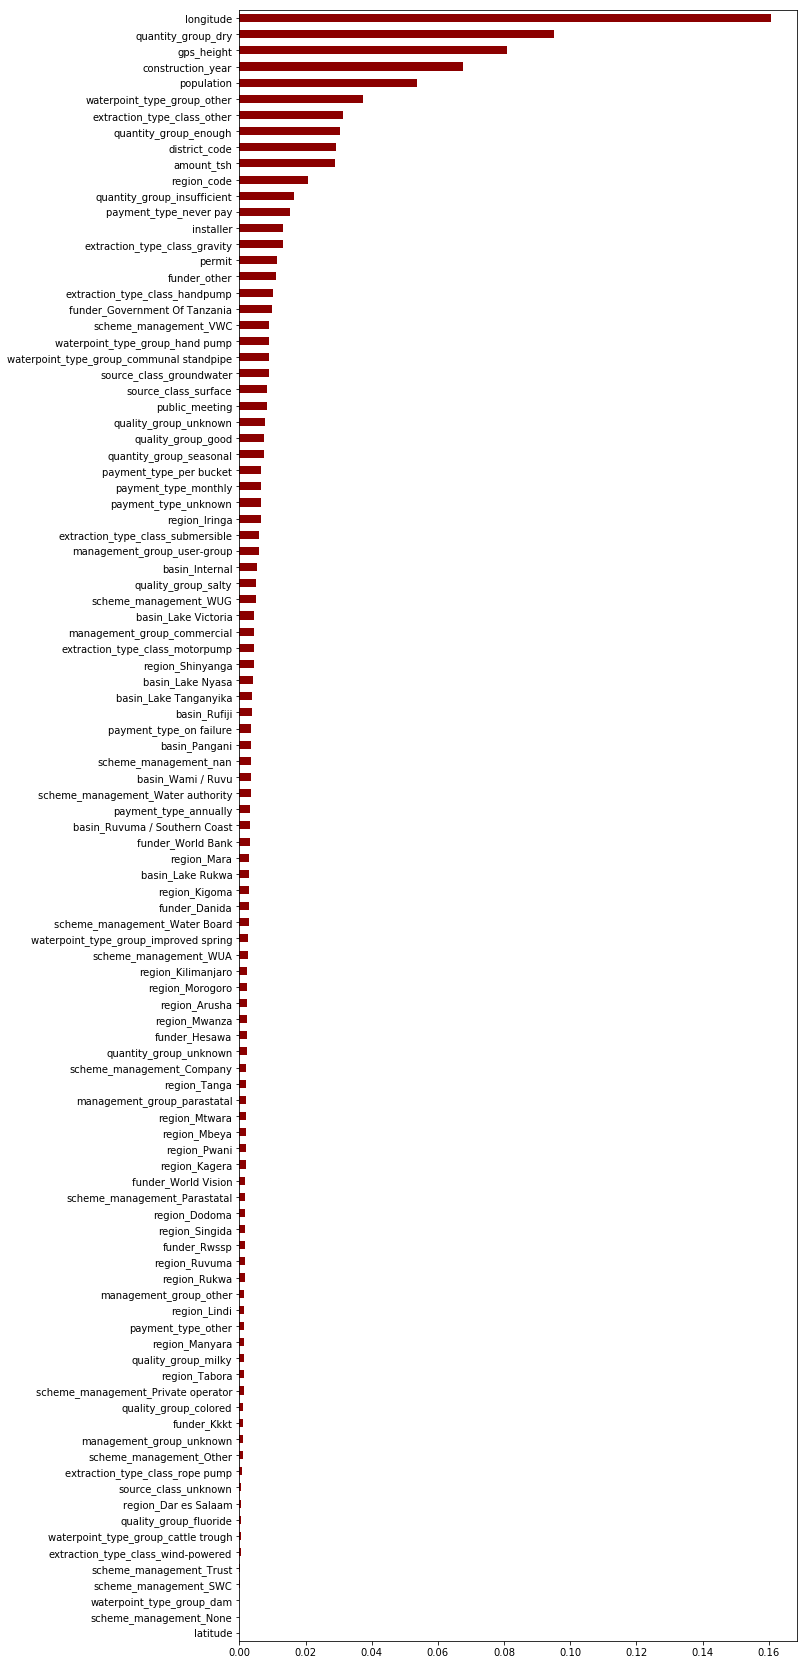

In [0]:
encoder = pipeline.named_steps['onehotencoder']
feat_columns = encoder.transform(X_train).columns
feat_importances = pipeline.named_steps['randomforestclassifier'].feature_importances_

fig = plt.figure(figsize=(10,30))
pd.Series(feat_importances,feat_columns).sort_values().plot.barh(color='darkred');

### Create prediction and submission

In [0]:
y_pred = pipeline.predict(test_features_clean)
submission = pd.Series(y_pred,test_id).reset_index().rename(columns={0:'status_group'})
submission.to_csv("Trevor_Tanzania_wells_2.csv",index=False)

## Lessons Learned
- We encode before imputing because the onehotencoder will handle nan's or null's in categorical data, the imputing will handle it for numerical data. So it saves time or computing power